In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os 

In [11]:
# **1. Preprocessing & Augmentasi Data**
train_dir = 'D:/Semester 3/CertanMatkul/PROYEK/HEWAN/Hewan2/training'
val_dir = 'D:/Semester 3/CertanMatkul/PROYEK/HEWAN/Hewan2/validation'
test_dir = 'D:/Semester 3/CertanMatkul/PROYEK/HEWAN/Hewan2/test'

In [13]:
# Parameter dataset
img_size = 180
batch_size = 32

In [17]:
# Augmentasi data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
# Load dataset
train_dataset = train_datagen.flow_from_directory(
    train_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode='sparse'
)

val_dataset = val_test_datagen.flow_from_directory(
    val_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode='sparse'
)

test_dataset = val_test_datagen.flow_from_directory(
    test_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode='sparse', shuffle=False
)

Found 4000 images belonging to 4 classes.
Found 4000 images belonging to 4 classes.
Found 4000 images belonging to 4 classes.


In [21]:
# *2. Transfer Learning (Base Model)*
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_size, img_size, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # Freeze base model

C:\Users\MSI\AppData\Local\Temp\ipykernel_22124\1167848564.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 5s 1us/step


In [23]:
# *3. Model CNN dengan 3x Lapisan Konvolusi*
model = models.Sequential([
    base_model,
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Layer konvolusi pertama
    layers.MaxPooling2D((2, 2), padding='same'),  # Max pooling dengan padding same
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),  # Layer konvolusi kedua
    layers.MaxPooling2D((2, 2), padding='same'),  # Max pooling dengan padding same
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),  # Layer konvolusi ketiga
    layers.MaxPooling2D((2, 2), padding='same'),  # Max pooling dengan padding same
    layers.GlobalAveragePooling2D(),  # Pooling global
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Dense layer
    layers.Dropout(0.5),  # Dropout untuk regularisasi
    layers.Dense(len(train_dataset.class_indices), activation='softmax')  # Output layer
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
# *4. Callback*
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

In [28]:
# *5. Training*
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[early_stopping, model_checkpoint]
)
#

D:\Semester 3\Certan\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.7401 - loss: 2.5764 - val_accuracy: 0.9513 - val_loss: 0.9226
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.9303 - loss: 0.8370 - val_accuracy: 0.9538 - val_loss: 0.4699
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.9330 - loss: 0.4804 - val_accuracy: 0.9580 - val_loss: 0.3003
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.9352 - loss: 0.3306 - val_accuracy: 0.9653 - val_loss: 0.1946
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.9441 - loss: 0.2455 - val_accuracy: 0.9680 - val_loss: 0.1629
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.9572 - loss: 0.2022 - val_accuracy: 0.9735 - val_loss: 0.1335
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9508 - loss: 0.1932 - val_accuracy: 0.9693 - val_loss: 0.1370
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9517 - loss: 0.1832 - val_accu

In [30]:
# *6. Fine-Tuning*
# Unfreeze beberapa lapisan terakhir
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.8813 - loss: 0.5772 - val_accuracy: 0.9740 - val_loss: 0.0921
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.9421 - loss: 0.2145 - val_accuracy: 0.9745 - val_loss: 0.0860
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9410 - loss: 0.1874 - val_accuracy: 0.9772 - val_loss: 0.0810
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.9515 - loss: 0.1599 - val_accuracy: 0.9780 - val_loss: 0.0802
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.9447 - loss: 0.1627 - val_accuracy: 0.9783 - val_loss: 0.0775
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.9525 - loss: 0.1598 - val_accuracy: 0.9787 - val_loss: 0.0772
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.9572 - loss: 0.1454 - val_accuracy: 0.9787 - val_loss: 0.0749
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.9634 - loss: 0.1388 - val_accu

In [32]:
# *7. Evaluasi*
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

125/125 ━━━━━━━━━━━━━━━━━━━━ 88s 707ms/step - accuracy: 0.9815 - loss: 0.0727
Test Accuracy: 98.00%


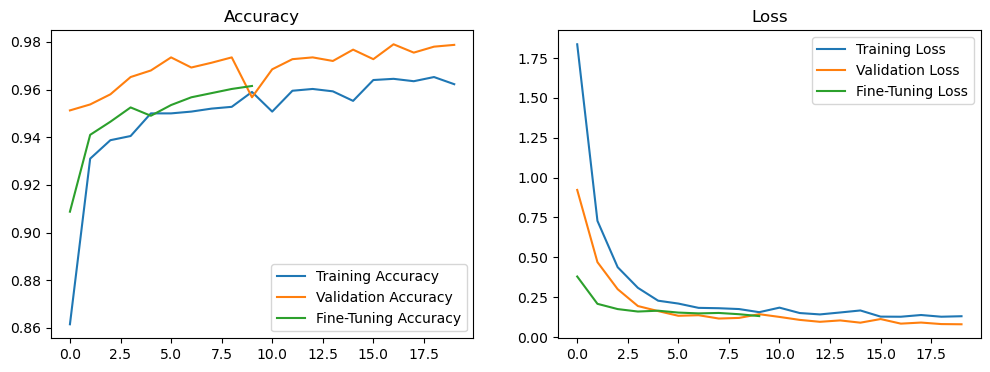

In [34]:
# *8. Visualisasi*
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(fine_tune_history.history['accuracy'], label='Fine-Tuning Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(fine_tune_history.history['loss'], label='Fine-Tuning Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [36]:
# *9. Save Model*
model.save('final_model.keras')

In [38]:
# *10. Confusion Matrix dan Classification Report*
predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_dataset.classes

125/125 ━━━━━━━━━━━━━━━━━━━━ 53s 406ms/step


In [40]:
print("\nClassification Report:\n")
print(classification_report(true_classes, predicted_classes, target_names=test_dataset.class_indices.keys()))


Classification Report:

              precision    recall  f1-score   support

     CHEETAH       0.97      0.98      0.98      1000
     HARIMAU       0.99      1.00      0.99      1000
 MACAN_TUTUL       0.97      0.97      0.97      1000
       SINGA       1.00      0.97      0.98      1000

    accuracy                           0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000



In [42]:
print("\nConfusion Matrix:\n")
print(confusion_matrix(true_classes, predicted_classes))


Confusion Matrix:

[[979   0  21   0]
 [  2 996   1   1]
 [ 22   1 975   2]
 [  4  14  12 970]]


In [44]:
# *RGB Processing*
def preprocess_rgb(image_path):
    image = tf.keras.utils.load_img(image_path, target_size=(img_size, img_size))
    image_array = tf.keras.utils.img_to_array(image)  # Convert image to array
    image_array = image_array / 255.0  # Normalize the image
    return image_array

In [56]:
# Contoh pemrosesan gambar RGB
image_path = r'D:\Semester 3\CertanMatkul\PROYEK\HEWAN\Hewan2\test\CHEETAH\lol.PNG'
image_rgb = preprocess_rgb(image_path)
print(image_rgb.shape)  # Harus menunjukkan (180, 180, 3) sebagai dimensi RGB

(180, 180, 3)


In [58]:
model = tf.keras.models.load_model('final_model.keras')

In [5]:
data_train_path = r'D:/Semester 3/CertanMatkul/PROYEK/HEWAN/Hewan2/training'
data_test_path = r'D:/Semester 3/CertanMatkul/PROYEK/HEWAN/Hewan2/test'
data_val_path = r'D:/Semester 3/CertanMatkul/PROYEK/HEWAN/Hewan2/validation'

In [7]:
img_width = 160
img_height =160 

In [11]:
import tensorflow as tf

# Path ke direktori dataset
data_train_path = r'D:/Semester 3/CertanMatkul/PROYEK/HEWAN/Hewan2/training'
data_test_path = r'D:/Semester 3/CertanMatkul/PROYEK/HEWAN/Hewan2/test'
data_val_path = r'D:/Semester 3/CertanMatkul/PROYEK/HEWAN/Hewan2/validation'

# Dimensi gambar
img_width, img_height = 128, 128

# Membuat dataset dari direktori
data_train = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    shuffle=True,
    image_size=(img_width, img_height),
    batch_size=32
)


Found 4000 files belonging to 4 classes.


In [12]:
data_train = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    shuffle=True,
    image_size=(img_width, img_height),
    batch_size=32
)

Found 4000 files belonging to 4 classes.


In [15]:
data_cat = data_train.class_names

In [17]:
data_cat

['CHEETAH', 'HARIMAU', 'MACAN_TUTUL', 'SINGA']

In [21]:
data_val = tf.keras.utils.image_dataset_from_directory(data_val_path,
                                                       image_size=(img_height,img_width),
                                                       batch_size=32,
                                                        shuffle=False,
                                                       validation_split=False)

Found 4000 files belonging to 4 classes.


In [23]:
data_test = tf.keras.utils.image_dataset_from_directory(
data_test_path,
    image_size=(img_height,img_width),
    shuffle=False,
    batch_size=32,
    validation_split=False
)

Found 4000 files belonging to 4 classes.


In [27]:
import matplotlib.pyplot as plt


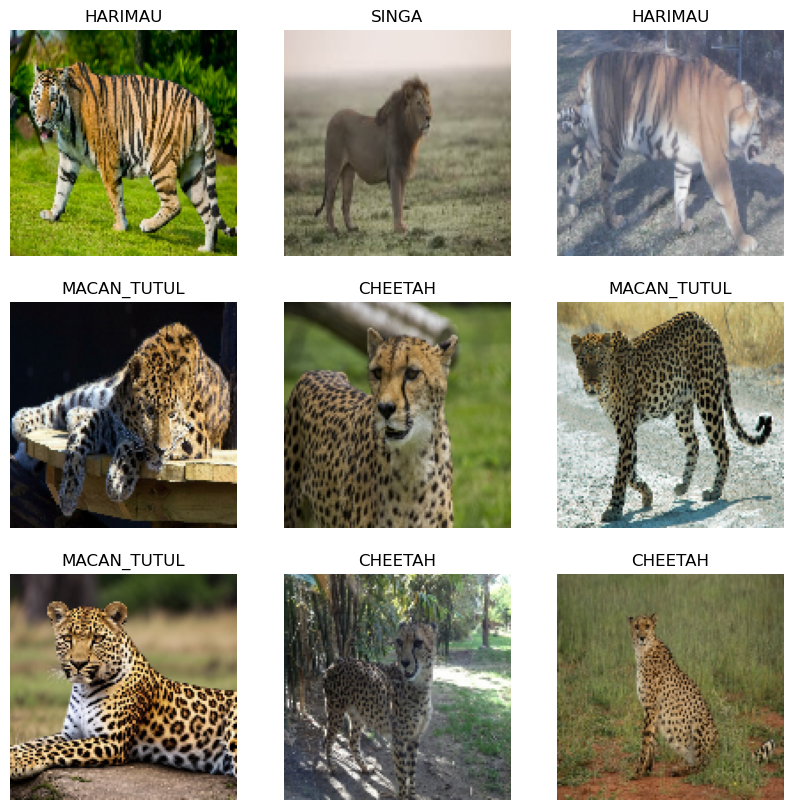

In [29]:
plt.figure(figsize=(10, 10))
for image, labels in data_train.take(1):  # Ambil satu batch dari dataset
    for i in range(9):  # Tampilkan 9 gambar
        plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(data_cat[labels[i].numpy()])  # Gunakan nama kelas dari label
        plt.axis('off')

plt.show()